# Modeling Credit Card Default risk

---
Sydeaka Watson, Ph.D.

June 2020


## Objective

In this notebook, we build a model that estimates the probability of credit card default. An account can default when the borrower fails to make timely payments as provisioned in the lending agreement.

**Background**

*Reference: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients*

This research aimed at the case of customers default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients.

The paper is available at the following link:
* https://github.com/wangzongyan/Default-of-credit-card-clients-Data-Project/blob/master/The%20comparisons%20of%20data%20mining%20techniques%20for%20the%20predictive%20accuracy%20of%20probability%20of%20default%20of%20credit%20card%20clients.pdf



**Attribute Information**:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
* X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
* X2: Gender (1 = male; 2 = female). 
* X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
* X4: Marital status (1 = married; 2 = single; 3 = others). 
* X5: Age (year). 
* X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
* X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 

## Summary of Modeling Results

* In this analysis, we compared results of logistic regression to those obtained using Gradient Boosted Machines (GBM) under 4 modeling scenarios.

* GBM yielded models with greater top decile lift in scenarios that (1) included all features or (2) only excluded payment status recorded one month before the default outcome was observed. However, these GBM models generally had higher values of logloss. Excluding payment status in the previous two or three months appeared to have only a modest effect on model performance.

* To avoid possible data leakage, I recommend using the GBM model that excludes September payment status.

## Things I'd do if I had more  time:

*  Try a neural network model (the paper suggested that it would have higher  performance).
  * I would switch from wide to long format and use a recurrent neural network model.

* Get a better understanding of the timing differences between bill due date vs payment date.
    * Primary, I'd like to incorporate the amount of time that elapses between the due date and payment deadline.
    * Could payment deadline actually be due next month? For example, billing statement date = Sept 20 but maybe payment is due Oct 1, i.e., in the following month.

* Get a better understanding of the minimum payments required and whether the borrowers paid those minimums.

* Get a better understanding of the relationship between payment status and observed bill/payment amounts. The status codes appear to be inconstent with actual payments recorded.   For this exercise, I  will use them  as-is.
  * Values of -2 and 0 were not defined in the data dictionary. I assumed that 0 is the code for zero payments made. However, the meaning of -2 is unclear. -2 usually corresponds to not owing anything, but sometimes occurs when bill  amount is  nonzero.
  * If using a recurrent neural  network model (LSTM, etc), we could more flexibly encode the temporal relationships between bill amounts and payment amounts in consecutive months.

* Investigate differential model performance across subgroups
    * Levels of individual categorical or binned numeric attributes
    * Across levels  of clusters determined using unsupervised learning

* Do more feature engineering to encode: 
    * interactive effects of predictor variables on default outcome
    * summaries of attributes over time to better model the temporal relationships among the attributes observed in each of the 6 months

* Try other modeling frameworks such as random forest, etc. 

* Try GBM with missing data imputed with mean values for more direct comparison between logisitic regression and GBM.



#  Setup

## Set parameters

In [0]:
# Set to 'colab' to execute code cells specifically needed for Google Colab
platform = 'other' 

In [2]:
if platform == 'colab':
    !pip install seaborn
    !pip install h2o
    !pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.1)


## Import modules

In [3]:
## General OS utilities
import shutil
import os
import datetime

## URL retrieval utilities
import urllib

## Misc modules for data transformations and processing
import pandas as pd
import numpy as np

## Graphics
from IPython.display import display #, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

## Modeling
from sklearn.model_selection import train_test_split
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Helper functions

Create a new folder at the specified path

In [0]:
def create_folder(folder_name):
    if os.path.isdir(folder_name):
        print('Folder "{}" exists'.format(folder_name))
    else:
        os.mkdir(folder_name)
        print('Folder "{}" created'.format(folder_name))

Pre-process the dataset

* Recode categorical attributes using mapping provided in data dictionary
* Recode payment status as number of delayed payments
* Rename payment status, bill amount, and payment amount columns to reflect month/year observed
* Create new attributes for (1) percent of bill paid and (2) percent credit utiliztation
* Drop any columns that are not needed (if desired/applicable)

In [0]:
def preprocess_df(df, exclude_cols = None):
  df = df.copy()

  df.SEX = df.SEX.map({1: 'male', 2:'female'})
  print(df.SEX.value_counts())

  df.EDUCATION = df.EDUCATION.map({1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others'})
  print(df.EDUCATION.value_counts())

  df.MARRIAGE = df.MARRIAGE.map({1: 'married', 2: 'single', 3: 'others'})
  print(df.MARRIAGE.value_counts())

  # Analyzing age as-is
  print(df.AGE.describe())
  
  months = ['2005_09', '2005_08', '2005_07', '2005_06', '2005_05', '2005_04']

  ## Percent of the bill paid (doesn't make sense due to timing inconsistencies 
  ## with bill date and payment due date possibly in different months)
  for i in range(0,6):
    j = str(i+1)
    mo = months[i]
    df['Pct_paid_' + mo] = round(100 * df['PAY_AMT' + j] / df['BILL_AMT' + j], 2)
  
  # Percent credit utilization
  for i in range(1,6):
    j = str(i+1)
    mo = months[i]
    df['Pct_cred_util_' + mo] = \
    round(100 * df['BILL_AMT' + j] / df['LIMIT_BAL'], 2)

  # Rename payment status columns
  pay_date_dict = {'PAY_6': 'PayStatus_2005_04',
  'PAY_5': 'PayStatus_2005_05',
  'PAY_4': 'PayStatus_2005_06',
  'PAY_3': 'PayStatus_2005_07',
  'PAY_2': 'PayStatus_2005_08',
  'PAY_1': 'PayStatus_2005_09'
  }
  df = df.rename(columns=pay_date_dict)

  ## Recode payment status
  pay_status_cols = list(pay_date_dict.values())

  ## 
  ## TO do: collapse 6+ into single group
  pay_delay_status_dict = {
      #-2: np.nan, # not defined in data dictionary, so setting to NA
      -1: 0, # interpreting as on-time payment
      0: 0, # interpreting as on-time payment (although not explicitly defined 
      # in data dictionary)
      1: 1, # 1 payments delayed
      2: 2, # 2 payments delayed
      3: 3, # 3 payments delayed
      4: 4, # 4 payments delayed
      5: 5, # 5 payments delayed
      6: 6, # 6 payments delayed
      7: 7, # 7 payments delayed
      8: 8, # 8 payments delayed
      9: 9  # 9 or more payments delayed
  }

  for pay_status_col in pay_status_cols:
    print(pay_status_col)
    df[pay_status_col] = df[pay_status_col].map(pay_delay_status_dict) 
    df[pay_status_col] = df[pay_status_col].astype('Int64')
    print(df[pay_status_col].value_counts())
    # to do: convert to int

  ## Recode bill amount
  bill_amt_dict = {
      'BILL_AMT1': 'Bill_amt_2005_09',
      'BILL_AMT2': 'Bill_amt_2005_08',
      'BILL_AMT3': 'Bill_amt_2005_07',
      'BILL_AMT4': 'Bill_amt_2005_06',
      'BILL_AMT5': 'Bill_amt_2005_05',
      'BILL_AMT6': 'Bill_amt_2005_04',
  }

  #bill_amt_cols = list(bill_amt_dict.values())
  df = df.rename(columns=bill_amt_dict)

  ## Recode payment amount
  payment_amt_dict = {'PAY_AMT1': 'Pay_amt_2005_09',
                      'PAY_AMT2': 'Pay_amt_2005_08',
                      'PAY_AMT3': 'Pay_amt_2005_07',
                      'PAY_AMT4': 'Pay_amt_2005_06',
                      'PAY_AMT5': 'Pay_amt_2005_05',
                      'PAY_AMT6': 'Pay_amt_2005_04'
                      }

  #payment_amt_cols = list(payment_amt_dict.values())
  df = df.rename(columns=payment_amt_dict)

  ## Drop columns
  if exclude_cols:
    df = df.drop(columns=exclude_cols)

  return df

Calculate default rates within each group level of a categorical variable

In [0]:
def rates_per_group(df, var_name):
  return df.groupby(var_name)[target_var].agg(['count', 'mean']).round(2)

Plot default rates across levels of a single categorical variable

In [0]:
def plot_default_rates_by_group(grp_rates, vname, ax):
    grp_rates[vname]['mean'].plot.bar(ax=ax)
    ax.set_title("Default rates by {}".format(vname))
    ax.set_ylabel("")
    ax.axhline(default_rate_overall/100, color='black', linestyle="dashed")

Combine default-rate-per-group plots across multiple categorical variables into a single plot

In [0]:
def plot_rates(grp_rates):
    fig, axs = plt.subplots(1, len(grp_rates), figsize=(30,5))
    axs = axs.reshape(-1)
    
    vnames = list(grp_rates.keys())

    for i in range(0, len(axs)):
        plot_default_rates_by_group(grp_rates, vnames[i], axs[i])

Get selected performance metrics for a single h2o model performance object

In [0]:
def get_perf_metrics(g):
    gl = g.gains_lift()
    lift_top_group = gl.as_data_frame().loc[0,:]['lift']

    return {'logloss': g.logloss(), 
            'precision': g.precision(), 
            'recall': g.recall(), 
            'auc': g.auc(), 
            'aucpr': g.aucpr(), 
            'tpr': g.tpr(), 
            'tnr': g.tnr(), 
            'fpr': g.fpr(), 
            'fnr': g.fnr(),
            'lift_top_group': lift_top_group
            }

Fit Logistic regression model for given feature set and return the model performance metrics

In [0]:
def fit_logreg(feature_set):
    glm_logistic = H2OGeneralizedLinearEstimator(family = "binomial")
    glm_logistic.train(x = feature_set, y = target_var, training_frame=h2o_train, 
                    model_id="glm_logistic")
    res = split_perf_metrics(glm_logistic)
    return res

Show model performance metrics for training, testing, and validation data splits

In [0]:
def split_perf_metrics(mod):
    perf = {'train': get_perf_metrics(mod.model_performance(test_data=h2o_train)),
    'test': get_perf_metrics(mod.model_performance(test_data=h2o_test)),
    'valid': get_perf_metrics(mod.model_performance(test_data=h2o_valid))}
    return pd.DataFrame(perf)

For a given model type, perform a grid search to find an optimal set of hyper parameter values

In [0]:
def grid_search(model_type = 'gbm', model_params = {},
                max_models = 3, seed = 157,  weights = (1.0, 5.0), features = None):

    # Search criteria
    search_criteria = {'strategy': 'RandomDiscrete', 'max_models': max_models, 'seed': seed}

    models = {'gbm': H2OGradientBoostingEstimator, 'rf': None}
    
    df_train['weight_col'] = df_train[target_var].map({0: weights[0], 1: weights[1]})
    h2o_train = h2o.H2OFrame(df_train)
    for  vname in  cat_vars:
        h2o_train[vname]  = h2o_train[vname].asfactor()
    
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    grid_id = "{}_grid_{}".format(model_type, timestamp)

    # Train and validate a cartesian grid of GBMs
    grid = H2OGridSearch(model = models[model_type],
                            grid_id = grid_id,
                            hyper_params = model_params,  
                            search_criteria = search_criteria )

    if model_type == 'gbm':
        grid.train(x=features, y=target_var,
                        training_frame=h2o_train,
                        validation_frame=h2o_valid,
                        categorical_encoding = 'enum',
                        seed=seed,
                    learn_rate_annealing=0.995,
                    nfolds = 3,
                   stopping_metric = "logloss", 
                   stopping_rounds = 10,
                   stopping_tolerance = 1e-4,
                   weights_column = 'weight_col'
                    )
    elif model_type == 'rf':
        print('do some stuff')
        ## TO DO: Implement random forest
    else:
        print("Model type '{}' is invalid.".format(model_type))

    # Get the grid results, sorted by validation AUC
    gridperf = grid.get_grid(sort_by='logloss', decreasing=False )

    # Get the grid results, sorted by validation AUC
    print('\nShow leaderboard\n')
    display(gridperf.sorted_metric_table())

    # Top model
    best_model = gridperf.models[0]

    # Save model to disk
    save_model(best_model, model_dir)

    return {'grid': grid, 'gridperf': gridperf, 'top model': best_model}

Download a file

In [0]:
def download_file(file_url, file_name = None):
    ## Download the file
    if file_name is None:
        file_name = os.path.join(data_dir, file_url.split('/')[-1].replace('%20', ' '))
        print(file_name)
    else:
        file_name = file_name.replace('%20', ' ')

    urllib.request.urlretrieve(file_url, file_name)
    print('File downloaded successfully!')

    return file_name

Save an h2o model, or load an h2o model from disk

In [0]:
def save_model(model, path):
    model_path = h2o.save_model(model=model, path=path, force=True)
    print("Model saved to {}".format(model_path))
    
def load_model(model_path):
    print("Loading model stored at {}".format(model_path))
    return h2o.load_model(model_path)

## If using Google Colab, Mount Google Drive


In [15]:
if platform == 'colab':
    ## Mount Google Drive
    from google.colab import drive
    drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Create directories

In [0]:
if platform == 'colab':
    data_dir = "/gdrive/My Drive/Colab Notebooks/data"
    model_dir = "/gdrive/My Drive/Colab Notebooks/models"
else:
    data_dir = 'data'
    model_dir = 'models'
    create_folder(data_dir)
    create_folder('models')

In [20]:
create_folder('output')
create_folder('plots')

Folder "output" exists
Folder "plots" exists


## Download dataset

In [21]:
data_file_name = download_file('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls')

/gdrive/My Drive/Colab Notebooks/data/default of credit card clients.xls
File downloaded successfully!


In [22]:
os.listdir(data_dir)

['gbm_grid_2020-06-14 14_52_17_model_64',
 'gbm_grid_2020-06-14 17_37_15_model_64',
 'gbm_grid_2020-06-14 16_45_23_model_60',
 'default of credit card clients.xls']

## Load and transform the dataset

Load the dataset

In [23]:
df0 = pd.read_excel(data_file_name,  header=1)
print("Dataset has {} rows and {} columns".format(df0.shape[0], df0.shape[1]))
df0  = df0.rename(columns={'PAY_0': 'PAY_1'})
df0.head(10)

Dataset has 30000 rows and 25 columns


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


Pre-processing of dataset using helper function created above

In [24]:
cols_to_exclude  = ['ID']
df = preprocess_df(df = df0, exclude_cols = cols_to_exclude)

female    18112
male      11888
Name: SEX, dtype: int64
university         14030
graduate school    10585
high school         4917
others               123
Name: EDUCATION, dtype: int64
single     15964
married    13659
others       323
Name: MARRIAGE, dtype: int64
count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64
PayStatus_2005_04
0    22026
2     2766
3      184
4       49
7       46
6       19
5       13
8        2
Name: PayStatus_2005_04, dtype: Int64
PayStatus_2005_05
0    22486
2     2626
3      178
4       84
7       58
5       17
6        4
8        1
Name: PayStatus_2005_05, dtype: Int64
PayStatus_2005_06
0    22142
2     3159
3      180
4       69
7       58
5       35
6        5
1        2
8        2
Name: PayStatus_2005_06, dtype: Int64
PayStatus_2005_07
0    21702
2     3819
3      240
4       76
7       27
6       23
5    

Show the first few rows of the processed dataset

In [25]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PayStatus_2005_09,PayStatus_2005_08,PayStatus_2005_07,PayStatus_2005_06,PayStatus_2005_05,PayStatus_2005_04,Bill_amt_2005_09,Bill_amt_2005_08,Bill_amt_2005_07,Bill_amt_2005_06,Bill_amt_2005_05,Bill_amt_2005_04,Pay_amt_2005_09,Pay_amt_2005_08,Pay_amt_2005_07,Pay_amt_2005_06,Pay_amt_2005_05,Pay_amt_2005_04,default payment next month,Pct_paid_2005_09,Pct_paid_2005_08,Pct_paid_2005_07,Pct_paid_2005_06,Pct_paid_2005_05,Pct_paid_2005_04,Pct_cred_util_2005_08,Pct_cred_util_2005_07,Pct_cred_util_2005_06,Pct_cred_util_2005_05,Pct_cred_util_2005_04
0,20000,female,university,married,24,2,2,0,0,<NA>,<NA>,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.00,22.21,0.00,NaN,NaN,NaN,15.51,3.44,0.00,0.00,0.00
1,120000,female,university,single,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0.00,57.97,37.29,30.56,0.00,61.33,1.44,2.24,2.73,2.88,2.72
2,90000,female,university,single,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,5.19,10.69,7.38,6.98,6.69,32.16,15.59,15.07,15.92,16.61,17.28
3,50000,female,university,married,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,4.26,4.19,2.43,3.89,3.69,3.38,96.47,98.58,56.63,57.92,59.09
4,50000,male,university,married,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,23.21,646.93,27.91,42.98,3.60,3.55,11.34,71.67,41.88,38.29,38.26


Identify target field and features

In [0]:
target_var = 'default payment next month'
target = df[target_var]
features = [x for x in  df.columns if x != target_var]

Split into training, testing, and validation sets (with features and target variable stored **SEPARATELY**)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target_var], test_size=0.30, random_state=157, stratify=target)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=157, stratify=y_test) 

Create training, testing, and validation sets (with features and target variable in **THE SAME** **dataframe**)

In [0]:
df_train = X_train.copy()
df_train[target_var] = y_train

df_test = X_test.copy()
df_test[target_var] = y_test

df_valid = X_valid.copy()
df_valid[target_var] = y_valid

# Exploratory Data Analysis

Overall default rate

In [29]:
default_rate_overall = round(100 * df[target_var].mean(), 2); default_rate_overall

22.12

The data splits were stratified by values of the default indicator. We end up with similar default rates in the training, testing, and validation sets.

In [30]:
## In training and testing sets (making sure they are about the same)
{'default_rate_train': round(100 * y_train.mean(), 2),  
 'default_rate_test': round(100 * y_test.mean(), 2),  
 'default_rate_valid': round(100 * y_valid.mean(), 2)}

{'default_rate_test': 22.13,
 'default_rate_train': 22.12,
 'default_rate_valid': 22.11}

Grouped total credit and age attributes added to the dataframe (for EDA only)

In [0]:
num_groups = 15

df['GRP_AMT'] = pd.cut(df.LIMIT_BAL,num_groups)
df['GRP_AGE'] = pd.cut(df.AGE,num_groups)

**Get default rates per level of categorical features and selected binned numeric features**

The overall (average) default rate of 22% is shown as a dashed horizontal line in each of the bar charts below. We observe that default risk is above average for:
* Male borrowers
* Borrowers with high school or university-level education
* Borrowers who are married or have 'other' relationship status
* Borrowers with credit limits under $142,000
* Borrowers under age 25 and most borrowers age 40 and above

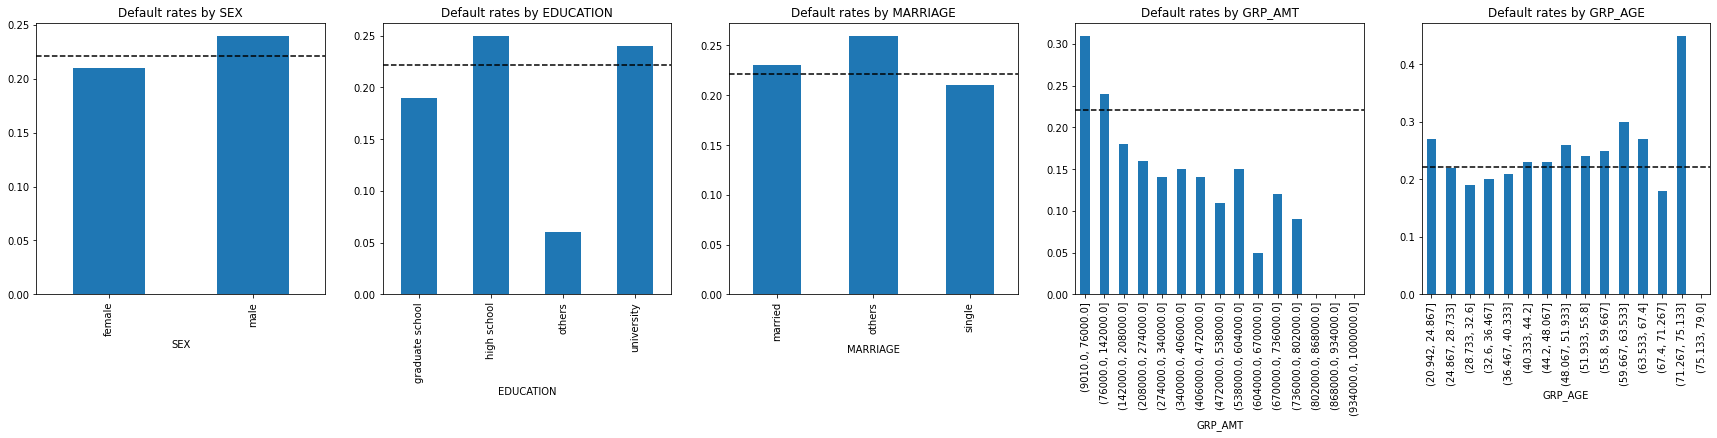

In [32]:
grp_vars = ['SEX', 'EDUCATION', 'MARRIAGE', 'GRP_AMT', 'GRP_AGE']
grp_rates = {vname: rates_per_group(df, vname) for vname in grp_vars}
plot_rates(grp_rates)

### Data leakage?

For the two months before the October 2005 default outcome was observed, default risk was above average for borrowers with September (69.55%) or August (56.03%) payment status of 2 or more. This suggests that either:

(1) Payment status is an extremely important indicator of default and should definitely be included in the model, or

(2) Payment status in the previous 2 months bleeds too much information into the model, resulting in data leakage.

Due to the magnitude of the influence attributed to these 2 months, I am inclined to believe the latter. However, there might be a scenario in which the end user would prefer to include these months in the model. Thus, in the modeling phase, I considered the following scenarios in which I 

1. kept all payment status variables, 
2. excluded September payment status only,
3. excluded both September and August payment status, or
4. excluded September, August, and July payment status (just to see what would happen).



In [33]:
## Default risk for payment status scores of 2 or more
{'PayStatus_2005_0' + str(i): str(round(100 * df[df['PayStatus_2005_0' + str(i)] >= 2][target_var].mean(), 1)) + ' %' for i in range(9,3,-1)}

{'PayStatus_2005_04': '52.3 %',
 'PayStatus_2005_05': '55.6 %',
 'PayStatus_2005_06': '53.5 %',
 'PayStatus_2005_07': '52.3 %',
 'PayStatus_2005_08': '56.0 %',
 'PayStatus_2005_09': '69.6 %'}

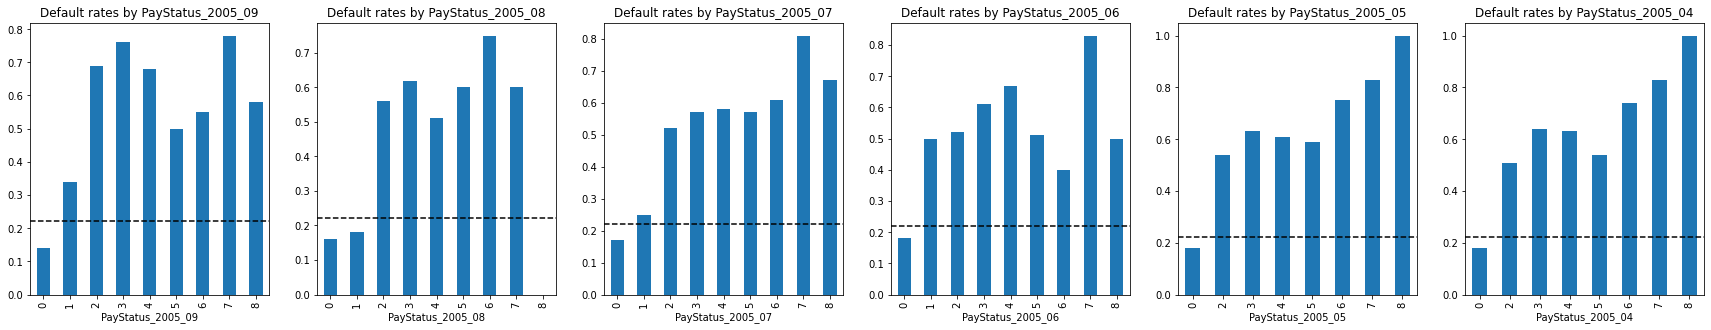

In [34]:
## Bar charts of default risk by payment status in each of the 6 months before 
## the default risk outcome was observed
grp_rates_pay_status = {'PayStatus_2005_0' + str(i): rates_per_group(df, 'PayStatus_2005_0' + str(i)) for i in range(9,3,-1)}
plot_rates(grp_rates_pay_status)

### Pairwise relationships

Pairwise relationships are shown in the plot below, with graphs stratified by default status.

I noticed a few instances in which there were strong pairwise relationships for one default status and a weak or non-existent trend for the other status.

With more time, I would have liked to dig into these a bit more and find some interactive relationships that I could manually encode and include in the feature set.


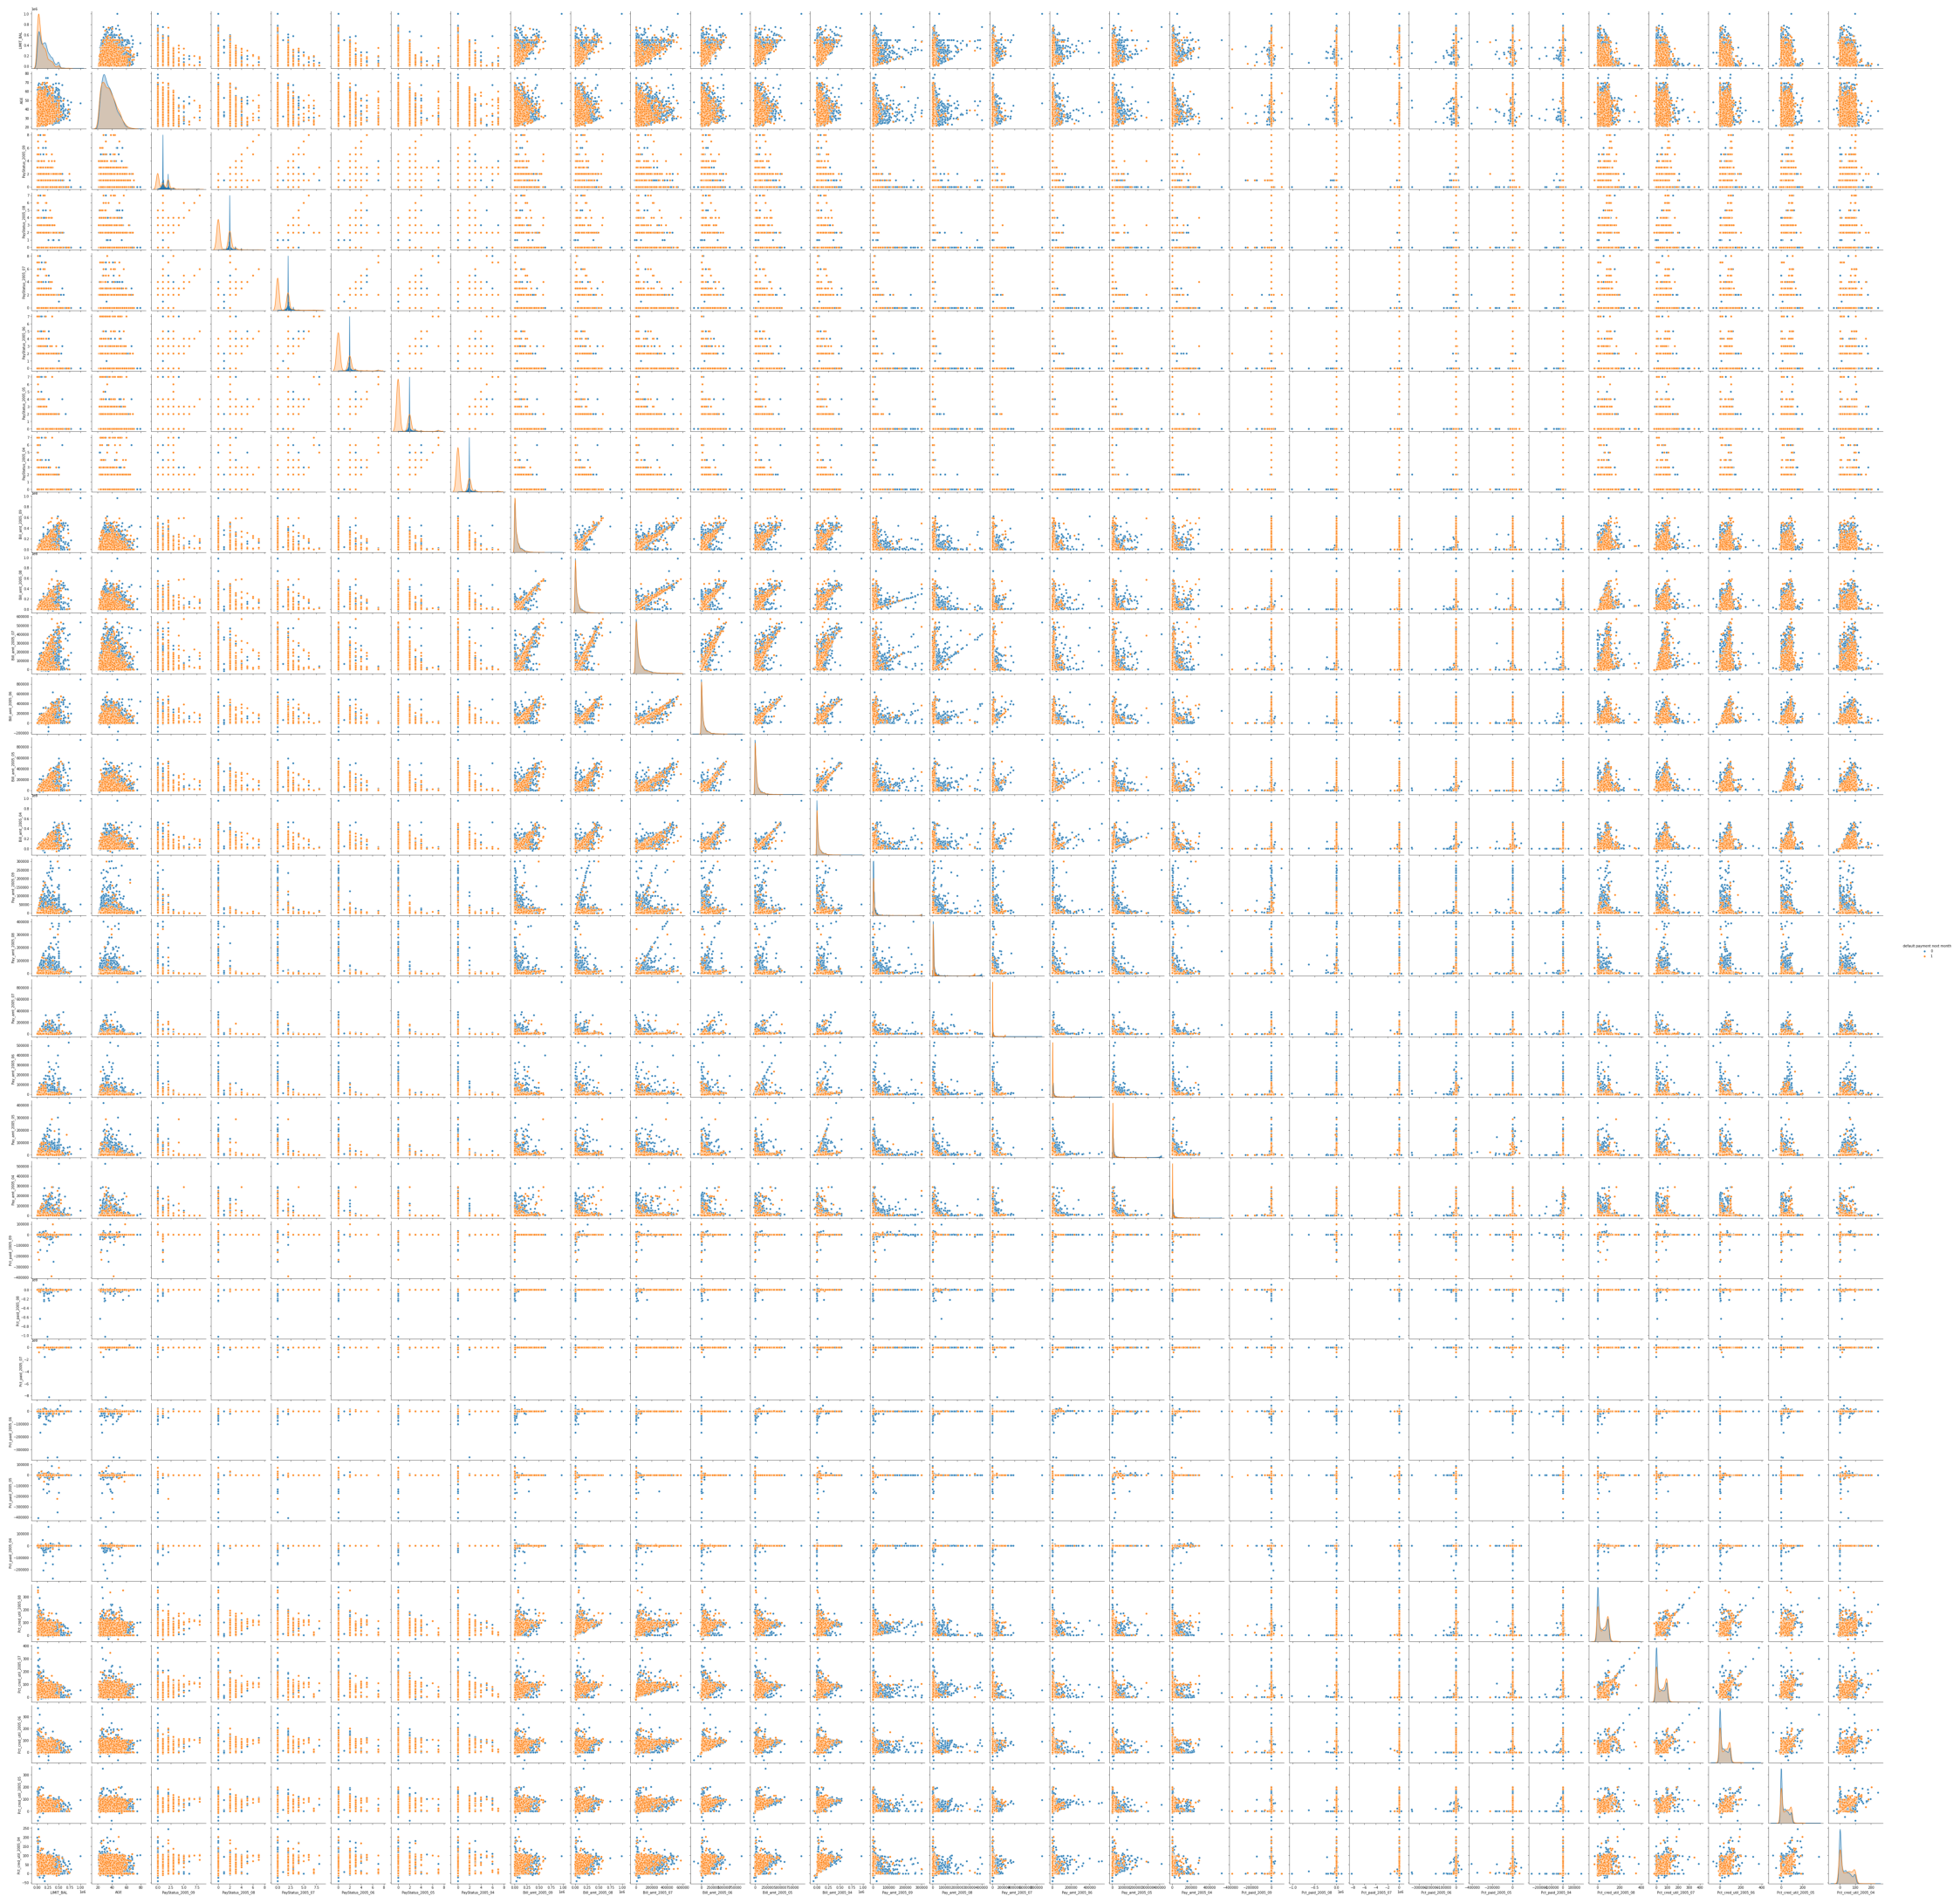

In [45]:
## Warning: It may take 10-20 minutes to create and render this plot
## By default, results are uploaded from a previously rendered copy saved to 
##    disk

refresh_pairwise_plot = False
pairwise_plot_file = 'plots/pairwise_plot.png'

if refresh_pairwise_plot:
    sel_var = df_train.columns
    pairwise_rel = sns.pairplot(df_train.reset_index().loc[1:10000,][sel_var], 
                                hue=target_var)
    pairwise_rel.savefig(pairwise_plot_file) 
    pairwise_rel
else:
    fsize = 40
    img=mpimg.imread(pairwise_plot_file)
    plt.figure(figsize = (fsize, fsize))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

# Modeling

## Modeling Strategy

* Use the tools implemented in **h2o** (https://www.h2o.ai/) to build statistical and machine learning models and evaluate performance. 
The models implemented in h2o can keep categorical variables intact without requiring recoding using one-hot encoding. These functions also natively keep missing values in the model without requiring imputation.

* Fit a logistic regression model as a baseline model. We'd expect machine learning alternatives to deliver superior performance, so this will give us a suitable benchmark against which we can evaluate other models. By default, this implementation of logistic regression will impute missing values using the mean value of the attribute.

* Using the Gradient Boosted Machine framework, I performed a grid search to find an optimal set of hyperparameters that will hopefully achieve  superior performance compared to the benchmark models. Due to time constraints, the number of models was limited to 75 models per scenario.

* Trends discussed/shared in the exploratory data analysis above indicated that there might be a risk of data leakage arising from payment status in the 2 months before the default outcome was observed. Thus, models were developed under the following scenarios in which the feature set
    1. included all payment status variables, 
    2. excluded September payment status only,
    3. excluded both September and August payment status,
    4. excluded September, August, and July payment status

* To adjust for the class imbalance in the default outcome, I increased the weight of the minority class (default, 22% of the observations) to have 2 times the weight of the majority class (non-default, 78%). I obviously could have tuned the class weight if I had more time.

* The following techniques were employed in order to enhance model generalizability:
    * Used 3-fold cross validation for each run in the grid search;
    * Used a validation set to monitor performance during the grid search;
    * Used early stopping criteria to halt model fitting if logloss failed to decrease by at least 1e-4 over 10 consecutive runs;
    * Evaluated final model performance using a held-out test set.

* Logloss was used as the primary performance metric during model development. However, lift in the top decile will also be monitored and recorded.





Create feature subset for the modeling scenarios

In [0]:
features_all = features
features_excl_sep = [x for x in features if x not in ['PayStatus_2005_09']]
features_excl_sep_aug = [x for x in features if x not in ['PayStatus_2005_09', 'PayStatus_2005_08']]
features_excl_sep_aug_jul = [x for x in features if x not in ['PayStatus_2005_09', 'PayStatus_2005_08', 'PayStatus_2005_07']]

# Set up h2o modeling environment

Initiate the h2o instance

In [47]:
h2o_obj  =  h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,14 mins 26 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_mje9aq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.177 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [0]:
#h2o.cluster().shutdown()

Convert the pandas dataframes to h2o dataframes

In [49]:
h2o_train = h2o.H2OFrame(df_train)
h2o_test = h2o.H2OFrame(df_test)
h2o_valid = h2o.H2OFrame(df_valid)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Convert categorical attributes to factor variables in the h2o dataframe

In [0]:
cat_vars = ['SEX', 'EDUCATION', 'MARRIAGE', target_var]

for  vname in  cat_vars:
    h2o_train[vname]  = h2o_train[vname].asfactor()
    h2o_test[vname] = h2o_test[vname].asfactor()
    h2o_valid[vname] = h2o_valid[vname].asfactor()

### Benchmark model: Logistic Regression

Model results for the logistic regression models are shown below. As expected, model performance degrades after removing the influence of July, August, and September payment status from the model.

In [51]:
## Feature subsets
feature_dict = {'features_all': features_all, 
                'features_excl_sep': features_excl_sep, 
                'features_excl_sep_aug': features_excl_sep_aug,
                'features_excl_sep_aug_jul': features_excl_sep_aug_jul
                }

## Logistic regression results
logreg_results = {key: fit_logreg(val) for key, val in feature_dict.items()}

print('\nGLM results: Lift in top decile')
logreg_res = {key: {
   'lift_top_decile': val.loc['lift_top_group']['test'],
   'logloss':  val.loc['logloss']['test'],
  }  for key, val in logreg_results.items()}
logreg_res

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%

GLM results: Lift in top decile


{'features_all': {'lift_top_decile': 3.112449799196787,
  'logloss': 0.4385769855770431},
 'features_excl_sep': {'lift_top_decile': 2.9116465863453818,
  'logloss': 0.4617185452155253},
 'features_excl_sep_aug': {'lift_top_decile': 2.9116465863453818,
  'logloss': 0.46888095626443715},
 'features_excl_sep_aug_jul': {'lift_top_decile': 2.9116465863453818,
  'logloss': 0.4749802445717652}}

In [52]:
pd.DataFrame(logreg_res)

,features_all,features_excl_sep,features_excl_sep_aug,features_excl_sep_aug_jul
lift_top_decile,3.112450,2.911647,2.911647,2.911647
logloss,0.438577,0.461719,0.468881,0.474980


## Grid search: GBM

In this section, we review the results of the 4 GBM grid search scenarios. For convenience, model results from a previous run are loaded from disk. Later in this section, we share the code used to produce these models.

### Show results of previously run models saved to disk

Dictionary of saved models

In [0]:
model_files = {
 'features_all': 'gbm_grid_2020-06-14 14_52_17_model_64',
 'features_excl_sep': 'gbm_grid_2020-06-14 16_45_23_model_60',
 'features_excl_sep_aug':  'gbm_grid_2020-06-14 17_37_15_model_64',
 'features_excl_sep_aug_jul': 'gbm_grid_2020-06-14 19:17:37_model_64'
}

Load the models from disk

In [54]:
model_obj = {
key: load_model(os.path.join(model_dir, val)) for key, val in model_files.items()
}

Loading model stored at /gdrive/My Drive/Colab Notebooks/models/gbm_grid_2020-06-14 14_52_17_model_64
Loading model stored at /gdrive/My Drive/Colab Notebooks/models/gbm_grid_2020-06-14 16_45_23_model_60
Loading model stored at /gdrive/My Drive/Colab Notebooks/models/gbm_grid_2020-06-14 17_37_15_model_64
Loading model stored at /gdrive/My Drive/Colab Notebooks/models/gbm_grid_2020-06-14 19:17:37_model_64


### Variable importance

**Scenario 1: All payment status features**

September 2005 payment status asserts the an overwhelming amount of influence on predictions in this model.

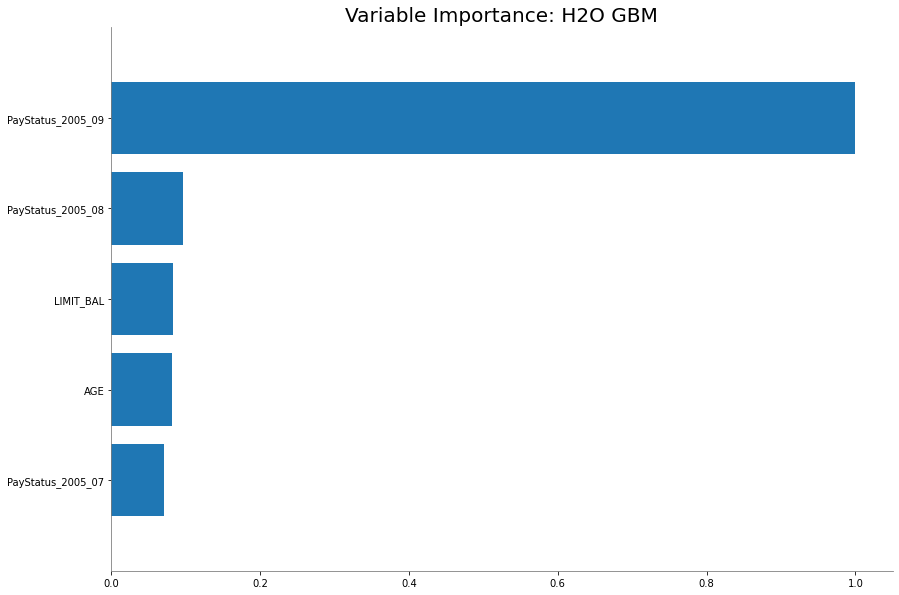

In [55]:
model_obj['features_all'].varimp_plot(num_of_features=5)

**Scenario 2: Excluding September payment status**

With September payment status excluded, now we see payment status for the next month (August) arising as the top predictor.

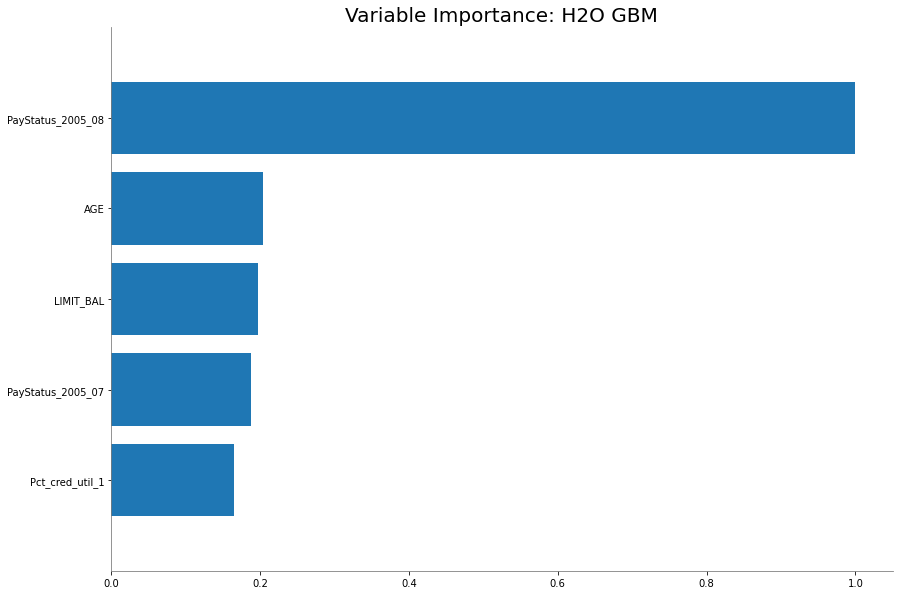

In [56]:
model_obj['features_excl_sep'].varimp_plot(num_of_features=5)

**Scenario 3: Excluding September and August payment status**

With September and August payment status out of the model, now we see the next month (July) as the top predictor.

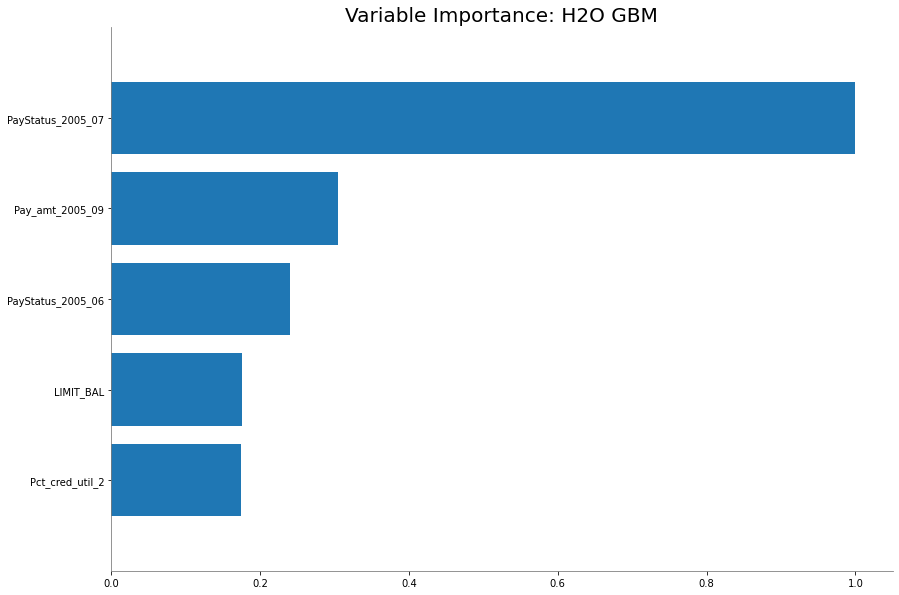

In [57]:
model_obj['features_excl_sep_aug'].varimp_plot(num_of_features=5)

**Scenario 4: Excluding September, August, and July payment status**

June payment status is the top predictor when we exclude September, August, and July payment status.

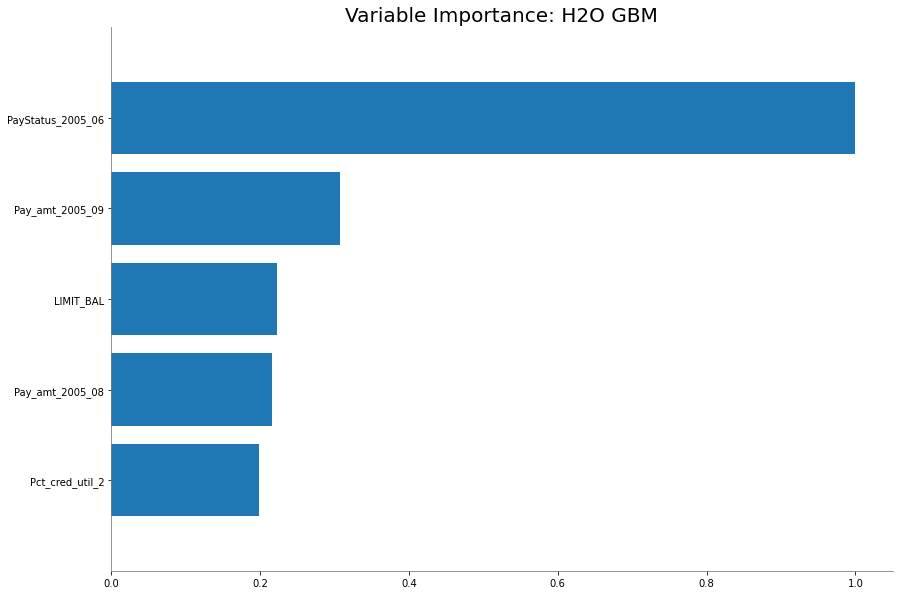

In [58]:
model_obj['features_excl_sep_aug_jul'].varimp_plot(num_of_features=5)

### Model results

Extract the log loss and top decile lift estimated using the held out test set

In [59]:
model_res = {key: {'logloss': split_perf_metrics(mod).loc['logloss']['test'],
                       'lift_top_decile': split_perf_metrics(mod).loc['lift_top_group']['test']} \
              for key, mod in model_obj.items()}

model_res

{'features_all': {'lift_top_decile': 4.116465863453815,
  'logloss': 0.44484153294577944},
 'features_excl_sep': {'lift_top_decile': 3.3132530120481927,
  'logloss': 0.48971471281653095},
 'features_excl_sep_aug': {'lift_top_decile': 2.9116465863453818,
  'logloss': 0.4772871042628195},
 'features_excl_sep_aug_jul': {'lift_top_decile': 3.112449799196787,
  'logloss': 0.47684761545056575}}

Here is a summary of the GBM model results as observed on the held out test set.

In [60]:
pd.DataFrame(model_res).sort_index()

,features_all,features_excl_sep,features_excl_sep_aug,features_excl_sep_aug_jul
lift_top_decile,4.116466,3.313253,2.911647,3.112450
logloss,0.444842,0.489715,0.477287,0.476848


For reference, we compare these to the logistic regression results as observed on the held out test set.

In [61]:
pd.DataFrame(logreg_res).sort_index()

,features_all,features_excl_sep,features_excl_sep_aug,features_excl_sep_aug_jul
lift_top_decile,3.112450,2.911647,2.911647,2.911647
logloss,0.438577,0.461719,0.468881,0.474980


### Summary of results

* In this analysis, we compared results of logistic regression with mean imputation to those obtained using Gradient Boosted Machines (GBM) without any missing value imputation under 4 modeling scenarios.

* GBM yielded models with greater top decile lift in scenarios that (1) included all features or (2) only excluded payment status recorded one month before the default outcome was observed. However, these GBM models generally had higher values of logloss. Excluding payment status in the previous two or three months appeared to have only a modest effect on model performance.

* To avoid possible data leakage, I recommend using the GBM model that excludes September payment status.

### Running the models from scratch

Warning: these models could take 30-60 minutes to run.

Hyperparameter grid over which I searched for an optimal combination of values yielding high model performance

In [0]:
gbm_params = {'learn_rate': [0.00001 * x for x in range(1, 10001)],
                'max_depth': list(range(6,15,1)),
                'sample_rate': [0.1 * x for x in range(6, 10)],
                'col_sample_rate': [0.1 * x for x in range(6, 10)],
                'ntrees': list(range(50, 900, 50))
               }

Scenario 1: Keep all of the payment status features

In [63]:
%%time

fit_model_from_scratch = False

if fit_model_from_scratch:
    gbm_grid = grid_search(model_type = 'gbm', model_params = gbm_params, 
                        max_models = 75, seed = 157,  weights = (1.0, 2.0), 
                        features = features_all)

    gbm_grid['top model'].varimp_plot()
    display(split_perf_metrics(gbm_grid['top model']))
else:
    print('Model not run.\n',
          'Set `fit_model_from_scratch = True` to run this model scenario.')

Model not run.
 Set `fit_model_from_scratch = True` to run this model scenario.
CPU times: user 3.23 ms, sys: 0 ns, total: 3.23 ms
Wall time: 2.77 ms


Scenario 2: Exclude September payment status from feature set.

In [64]:
%%time

fit_model_from_scratch = False

if fit_model_from_scratch:
    gbm_grid = grid_search(model_type = 'gbm', model_params = gbm_params, 
                        max_models = 75, seed = 157,  weights = (1.0, 2.0), 
                        features = features_excl_sep)

    gbm_grid['top model'].varimp_plot()
    display(split_perf_metrics(gbm_grid['top model']))
else:
    print('Model not run.\n',
          'Set `fit_model_from_scratch = True` to run this model scenario.')

Model not run.
 Set `fit_model_from_scratch = True` to run this model scenario.
CPU times: user 2.71 ms, sys: 955 µs, total: 3.67 ms
Wall time: 3.82 ms


Scenario 3: Exclude September and August payment status from feature set.

In [65]:
%%time

fit_model_from_scratch = False

if fit_model_from_scratch:
    gbm_grid = grid_search(model_type = 'gbm', model_params = gbm_params, 
                        max_models = 75, seed = 157,  weights = (1.0, 2.0), 
                        features = features_excl_sep_aug)

    gbm_grid['top model'].varimp_plot()
    display(split_perf_metrics(gbm_grid['top model']))
else:
    print('Model not run.\n',
          'Set `fit_model_from_scratch = True` to run this model scenario.')

Model not run.
 Set `fit_model_from_scratch = True` to run this model scenario.
CPU times: user 3.09 ms, sys: 1.04 ms, total: 4.13 ms
Wall time: 3.63 ms


Scenario 4: Exclude September, August, and July payment status from feature set.

In [66]:
%%time

fit_model_from_scratch = False

if fit_model_from_scratch:
    gbm_grid = grid_search(model_type = 'gbm', model_params = gbm_params, 
                        max_models = 75, seed = 157,  weights = (1.0, 2.0), 
                        features = features_excl_sep_aug_jul)

    gbm_grid['top model'].varimp_plot()
    display(split_perf_metrics(gbm_grid['top model']))
else:
    print('Model not run.\n',
          'Set `fit_model_from_scratch = True` to run this model scenario.')

Model not run.
 Set `fit_model_from_scratch = True` to run this model scenario.
CPU times: user 2.74 ms, sys: 846 µs, total: 3.59 ms
Wall time: 4.8 ms


# Shut down the h2o cluster

In [67]:
h2o.cluster().shutdown()

H2O session _sid_ae40 closed.
